In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [33]:
transform = transforms.Compose([transforms.ToTensor()])

In [34]:
train_dataset = datasets.FashionMNIST(root = "Data",
                                      train=True,
                                      download=True,
                                      transform=transform)
val_dataset = datasets.FashionMNIST(root = "Data",
                                      train=False,
                                      download=True,
                                      transform=transform)
test_dataset = datasets.FashionMNIST(root = "Data",
                                      train=False,
                                      download=True,
                                      transform=transform)

In [35]:
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [36]:
for idx, (x, y) in enumerate(train_dataset):
    print(x.shape)
    print(y)
    if idx > 5:
        break

torch.Size([1, 28, 28])
9
torch.Size([1, 28, 28])
0
torch.Size([1, 28, 28])
0
torch.Size([1, 28, 28])
3
torch.Size([1, 28, 28])
0
torch.Size([1, 28, 28])
2
torch.Size([1, 28, 28])
7


In [37]:
train_loder = torch.utils.data.DataLoader(dataset= train_dataset,
                                          batch_size=64,
                                          shuffle=True)

val_loder = torch.utils.data.DataLoader(dataset= val_dataset,
                                          batch_size=64,
                                          shuffle=True)

test_loder = torch.utils.data.DataLoader(dataset= test_dataset,
                                          batch_size=64,
                                          shuffle=True)

In [38]:
for x, y in train_loder:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


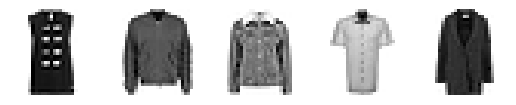

tensor([0, 4, 4, 6, 4])

In [39]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(x[i, :,:,:].reshape(28,28), cmap="gray_r")
plt.show()
y[:5]

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(3 * 3 * 32, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = x.view(-1, 3 * 3 * 32)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [41]:
model = FashionCNN().to(torch.device('cpu'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

FashionCNN(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [42]:
def train(model, train_loder, optimizer):
    model.train()
    for idx, (images, labels) in enumerate(train_loder):
        images = images.to(torch.device('cpu'))
        labels = labels.to(torch.device('cpu'))
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
            print(f"Batch : {idx}, Loss : {loss.item()}")

In [43]:
def evaluate(model, test_loader):
    loss_total = 0
    correct_total = 0
    model.eval() # 평가모드로 설정 -> batch_normalization, drop_out 수행 중지
    with torch.no_grad(): #가중치 업데이터 수행 중지
        for images, labels in test_loader:
            images = images.to(torch.device('cpu'))
            labels = labels.to(torch.device('cpu'))
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss
            predicted_values = output.max(1, keepdim = True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
            correct_total += correct

    loss_total = loss_total / ( len(test_dataset) / 64 )
    # loss_total /= ( len(test_dataset) / 32 )

    accuracy = correct_total / len(test_dataset)

    return loss_total, accuracy

In [44]:
for epoch in range(10):

    train(model= model, train_loder=train_loder, optimizer= optimizer)
    loss, acc = evaluate(model, val_loder)
    print(f"Epoch : {epoch + 1}, Loss : {loss}, Accuracy : {acc}")

Batch : 0, Loss : 2.3161752223968506
Batch : 100, Loss : 0.7827268838882446
Batch : 200, Loss : 0.7305614352226257
Batch : 300, Loss : 0.7127848863601685
Batch : 400, Loss : 0.6978611350059509
Batch : 500, Loss : 0.5498799681663513
Batch : 600, Loss : 0.47614651918411255
Batch : 700, Loss : 0.6010541915893555
Batch : 800, Loss : 0.4413156509399414
Batch : 900, Loss : 0.6746379137039185
Epoch : 1, Loss : 0.5626106533050537, Accuracy : 0.7917
Batch : 0, Loss : 0.5231672525405884
Batch : 100, Loss : 0.5870362520217896
Batch : 200, Loss : 0.42936035990715027
Batch : 300, Loss : 0.438965380191803
Batch : 400, Loss : 0.3742099404335022
Batch : 500, Loss : 0.4316185712814331
Batch : 600, Loss : 0.4663742482662201
Batch : 700, Loss : 0.3924182057380676
Batch : 800, Loss : 0.3807239532470703
Batch : 900, Loss : 0.4274046719074249
Epoch : 2, Loss : 0.4568523025512695, Accuracy : 0.8349
Batch : 0, Loss : 0.42148834466934204
Batch : 100, Loss : 0.60946124792099
Batch : 200, Loss : 0.39340689778327

In [45]:
evaluate(model= model, test_loader= test_loder)

(0.29635666823387147, 0.8941)